### Projet Python Clustering de journaux

Henry Faure-Geors et Tanguy Laucournet

## Introduction

Voici notre rapport de projet sur le clusturing de journaux. Dans ce rapport, nous aborderons les fonctions de notre programme ainsi que les conclusions que nous avons pu tirer de l’interprétation des résultats


## Le projet

L’objectif durant ce projet était de faire du scraping des journaux afin de récupérer des articles pour ensuite utiliser un algorithme non supervisé afin de faire de la prédiction de catégorie d’article (via clustering). Pour ce faire, nous avons principalement utilisé BeautifulSoup et request afin de récupérer le corps du site que nous avons choisi : Les échos, ainsi que les urls d’articles catégorisé par le site (par exemple économie, Politique, Monde, …). Nous employons ensuite une méthode pour récupérer le texte de ces articles et nous les stockons.

Afin de réaliser le clustering, nous allons tout d’abord préparer nos données en utilisant la fonction TfidfVectorizer de la librairie sklearn.feature_extraction.text tout en lui fournissant une liste de sw que nous aurons étendu manuellement afin d’éliminer des mots que nous jugeons inutile pour le clustering et que nous avons observé au fil de nos test. Après avoir créé notre matrice répertoriant la fréquence des mots dans nos texte, nous entrainons un model kmeans que nous utiliserons pour déterminer à quel Cluster appartient un article donné en paramètre. 


In [55]:
from requests import get
import bs4 as bs
import nltk
from bs4 import BeautifulSoup
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Fonction permettant de récupérer les urls de tous les articles présent sur une page web

In [56]:
def Fetch_Url(url, array):
    tempo_arr = []
    response = Check_Web_Connection(url)
    soup = Get_Web_Soup(response)
    body = soup.find(id='app')
    articles = body.find_all('div',class_="sc-AxjAm sc-1ttlxdz-0 bTKqUl")
    for elem in articles:
        url = elem.find_all('a',href=True)
        for i in url:
            tempo_arr.append(i['href'])
    for i in range(50): # defini le nbr d'article prix
        
        if i%2 == 0:
            array.append(tempo_arr[i])


In [58]:
url_array = []
pol = 'https://www.lesechos.fr/politique-societe'
eco="https://www.lesechos.fr/economie-france"
monde="https://www.lesechos.fr/monde"
tech="https://www.lesechos.fr/tech-medias"
entreprise="https://www.lesechos.fr/industrie-services"
bourse="https://www.lesechos.fr/bourse"
finance="https://www.lesechos.fr/finance-marches"
region="https://www.lesechos.fr/pme-regions"
patrimoine="https://www.lesechos.fr/patrimoine"
url_array.append(Fetch_Url(pol,url_array))
url_array.append(Fetch_Url(eco,url_array))
url_array.append(Fetch_Url(monde,url_array))
url_array.append(Fetch_Url(tech,url_array))
url_array.append(Fetch_Url(entreprise,url_array))
url_array.append(Fetch_Url(bourse,url_array))
url_array.append(Fetch_Url(finance,url_array))
url_array.append(Fetch_Url(region,url_array))
url_array.append(Fetch_Url(patrimoine,url_array))

print(url_array)

['/politique-societe/gouvernement/loi-climat-lassemblee-renforce-la-vigilance-sur-la-publicite-1304253', '/politique-societe/societe/marlene-schiappa-appelle-a-la-responsabilite-et-denonce-lindignite-de-lopposition-1304173', '/politique-societe/societe/fermeture-des-ecoles-les-embuches-a-surmonter-pour-lenseignement-a-distance-1304141', '/politique-societe/regions/covid-les-communes-sous-pression-avec-la-fermeture-des-ecoles-1304048', '/politique-societe/societe/confinement-les-assistantes-maternelles-finalement-autorisees-a-garder-les-enfants-1304019', '/politique-societe/societe/lidee-dun-revenu-de-base-pour-les-18-24-ans-fait-son-chemin-1304010', '/politique-societe/gouvernement/projet-de-loi-climat-les-deputes-recadrent-les-engagements-volontaires-des-entreprises-1303960', '/politique-societe/societe/concours-dacces-aux-grandes-ecoles-pas-de-test-pcr-pour-les-epreuves-ecrites-1303942', '/politique-societe/societe/covid-les-questions-que-pose-le-reconfinement-1303940', '/pme-regions

In [59]:
len(url_array)

234

In [75]:
content = []
new_url = []
label = []
titles = []
for i in url_array: 
  url = 'https://www.lesechos.fr'
  if i !=None and '.php'not in i: # drop some article with missing informations
    url+= str(i) #in order to get the differents pages url
    response = get(url)
    html_soup = BeautifulSoup(response.text,'html.parser')
    body = html_soup.find(id='app')
    main_art = body.find_all('p',class_="sc-AxirZ bUHJAM") # get article content
    title = body.find('header',class_='cyue7g-0 bWrNQA') # get article title
    titles.append(title.get_text())
    fullarticle = ''
    for itm in main_art:
      fullarticle += itm.get_text().replace('\xa0',' ').replace('\u202f',' ') # clean article content
    content.append(''.join([i for i in fullarticle if not i.isdigit()]))
    new_url.append(url+str(i))
    label.append(str(i).split('/')[1])

Création d'une dataframe pandas avec les donées récupérées

In [61]:
data  = pd.DataFrame({
        'titles': titles,
        'contents': content,
        'urls': new_url,
        'labels': label
})

In [62]:
print("Nombre d'artciles conservés: "+str(len(content)))

Nombre d'artciles conservés: 200


Netoyage des données

In [63]:
nltk.download("stopwords")
nltk.download('punkt')
sw = stopwords.words('french') 
sw.extend(['a',"d'","n'","l'",'plus','moins','être','comme','avoir','ici','faire','faut','non','dit','ans','2020','2021','cette','mois','depuis','tous','contre','sous','cet']) # useless words to drop from contents

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Clusterisation

In [64]:

vectorizer = TfidfVectorizer(stop_words=sw)
text = data['contents'].values.astype("U")
X = vectorizer.fit_transform(text)
true_k = 5 # clusters number
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [65]:
result =[]

for i in range(true_k):
  print("Cluster %d:" + str(i))
  word_number = 10 # number of word for each clusters
  temp = []
  for ind in order_centroids[i, :word_number]:
    temp.append(terms[ind])
    
    print(terms[ind])
  result.append(temp)

data['cluster']= model.labels_

Cluster %d:0
seine
euros
millions
marne
ligne
prix
saint
val
département
denis
Cluster %d:1
loi
projet
publicité
sociale
engagements
telle
annuel
capital
csa
amendement
Cluster %d:2
milliards
dollars
euros
année
an
banque
épargne
comptes
trimestre
groupe
Cluster %d:3
centre
story
abonner
annulation
ville
toulouse
deux
centres
métropole
plui
Cluster %d:4
covid
france
millions
vaccination
ministre
vaccin
écoles
gouvernement
nouvelles
mesures


In [66]:
pd.set_option('display.max_rows', None)
data.head()

,titles,contents,urls,labels,cluster
0,Loi climat : l'Assemblée renforce la vigilance...,"Les allégations écologiques des publicitaires,...",https://www.lesechos.fr/politique-societe/gouv...,politique-societe,1
1,Marlène Schiappa appelle « à la responsabilité...,Alors qu'un troisième confinement vient d'entr...,https://www.lesechos.fr/politique-societe/soci...,politique-societe,4
2,Fermeture des écoles : les embûches à surmonte...,A partir de ce mardi s'ouvre une période d'ens...,https://www.lesechos.fr/politique-societe/soci...,politique-societe,4
3,Covid : les communes sous pression avec la fer...,Branle-le-bas de combat dans les communes en v...,https://www.lesechos.fr/politique-societe/regi...,politique-societe,4
4,Confinement : les assistantes maternelles fina...,Le gouvernement a changé d'avis sur les assist...,https://www.lesechos.fr/politique-societe/soci...,politique-societe,4


In [67]:
def createComparisonArray(labels): # function that takes an iterable and returns an array with true value for each value wich are the same base on the index
  label_array = []
  for i in  labels:
    temp =[]
    for j in labels:
      if i == j:
        temp.append(True)
      else:
        temp.append(False)
    label_array.append(temp)
  return label_array

In [68]:
label_array = createComparisonArray(data['labels'])
cluster_array = createComparisonArray(data['cluster'])

In [69]:
def array_comparison(first_array,second_array): #function to compare two array that return the average similarity
  res=0
  for i in range(0,len(first_array)):
    for j in range(0,len(first_array[0])):
      if first_array[i][j]== second_array[i][j]:
        res+=1
  final_res = res / (len(first_array)*len(first_array[0]))
  
  return final_res



In [70]:
print(array_comparison(label_array,cluster_array))

0.67485


Fonction pour automatiser le clustering et y appliquer différents paramètres

In [71]:
def clustering(nb_cluster,nb_word):
  
  model = KMeans(n_clusters=nb_cluster, init='k-means++', max_iter=100, n_init=1)
  model.fit(X)

  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer.get_feature_names()

  result =[]

  for i in range(nb_cluster):
    temp = []
    for ind in order_centroids[i, :nb_word]:
      temp.append(terms[ind])
    
      
    result.append(temp)

  labels_comparison = createComparisonArray(data['labels'])
  cluster_array = createComparisonArray(model.labels_)
  a=array_comparison(label_array,cluster_array)
  return a


Test pour de 1 à 29 cluster avec 1 à 29 mots par cluster

In [72]:
res_array = []

for i in range(1,30):
  temp = []
  for j in range(1,30):
    x= clustering(i,j)
    temp.append(x)
  res_array.append(temp)

Moyenne des résultat pour chaque nombre de cluster ( de 1 à 29)

[0.12509999999999988, 0.3940034482758621, 0.5140982758620689, 0.5933362068965518, 0.6423413793103447, 0.6656706896551725, 0.6918465517241381, 0.7224224137931036, 0.7397137931034481, 0.7326258620689655, 0.7474000000000001, 0.7564206896551723, 0.7964465517241379, 0.7759344827586208, 0.768889655172414, 0.7982017241379311, 0.7981051724137933, 0.8082637931034483, 0.7972741379310344, 0.8201706896551725, 0.8085224137931032, 0.8126206896551725, 0.8231827586206897, 0.8234189655172414, 0.8232275862068964, 0.8286879310344829, 0.8280637931034484, 0.8319137931034482, 0.8334844827586205]


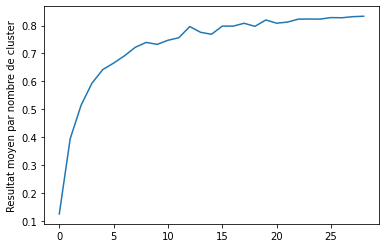

In [73]:
avg_res= []
for elem in res_array:
  temp = 0
  for itm in elem:
    temp+=itm
  avg_res.append(temp / 29)

print(avg_res)

plt.plot(avg_res)
plt.ylabel('Resultat moyen par nombre de cluster')
plt.show()

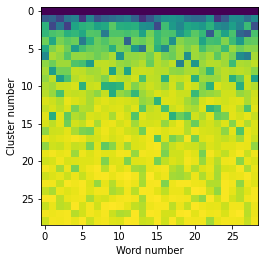

In [74]:

plt.xlabel("Word number")
plt.ylabel("Cluster number")
plt.imshow(res_array)
plt.show()

## Interpretation du programme

Afin de vérifier l’efficacité de notre algorithme, nous avons créé une fonction permettant de tester la précision de notre kmeans. Nous avons effectué différent test en faisant varier le nombre de cluster ainsi que le nombre de mots par cluser et comparé la précision du clustering. Notre meilleure précision est atteinte lorsque nous choisissons 24 cluster. Il est également important de souligner que le nombre de mots par cluster n’influence pas ce nombre de cluster et que cela dépend donc juste de la diversité des articles.

On peut expliquer ces résultats de différentes manières. 

Tout d’abord, l’actualité est centrée autour d’un theme assez récurrent qui est celui de la Covid-19. C’est pourquoi des mêmes termes reviennent souvent ce qui provoque une disparité dans les clusters (certains cluster vont être composé de mots venant de 3 articles, d’autre de 15). 

De plus, nous avons scrap des articles venant de catégorie comme « Région » ou bien encore « Patrimoine », or dans ces catégories, des articles peuvent aussi bien traiter de sport, de gastronomie, de tourisme ou d’animaux, ce qui peut expliquer la présence de nombreux cluster différent. Cependant, augmenter de façon importante le nombre de cluster va ainsi pousser ces articles qui n’ont rien à voir l’un de l’autre à créer des cluster encore plus petits et ainsi faire perdre en précision. Par exemple, sur une base de 10 articles, si chacun est totalement différent et qu’il y a 8 cluster, il sera très dur pour le modèle de définir à quel cluster appartient un article donné.

Cependant, tandis que l’augmentation du nombre de cluster brouille la précision, il permet également d’avoir une potentielle séparation dans le grand cluster de la Covid dépendant des articles du moment. Comme les articles peuvent traiter de l’impact de la Covid dans des milieux comme l’économie, la santé, le tourisme, on a pu voir l’apparition d’un deuxieme cluster Covid durant les test, un traitant plus du vaccins, et l’autre de son impact sur l’éducation.

## Conclusion

Ce projet nous a permis de développer nos compétences en python mais également nos connaissances du non supervisé et comment faire varier la précision des modèles.